# Annotation dataset selection

**Description**

Notebook for the selection of a reduced set of interviews for:
  1. IRR Annotation
  2. General annotation after IRR

We need a small dataset because it is infeasable to annotate all ~24,500 calls, so:
  1. We want "good" as well as "bad" interviews for our ML models.
  2. We need a random sample.
  3. We have a limited amount of transcribed interviews scored by experts.
  4. The resulting set will need manual quality control for quality audio.

Data used in this notebook (./data/...)
  1. For global ratings, interview IDs and participant IDS: `LIVES_Call-Level_Data_all_fidelity_scored_calls_n=323_trimmed.xls`
  2. For background information (English interviews): `LIVES_Outcome_Data_BL-24M_ppts_from_fidelity_list_n=173_trimmed.xlsx`
  3. For background information (Spanish interviews): `HIspanic_ppts_tracking_and_outcomes_6.23.21.xlsx_trimmed`
  4. For pilot interview data `pilot_interview_annotation_en.csv` and `pilot_interview_annotation_es.csv`
  5. All the files are available directly for use in: https://arizona.box.com/s/19qgcvob3m0qr803bswi7ggjrelcj3s2

Computing "good" and "bad" interview distributions
  1. Use the Global Spirit Rating from MITI 3.0 Scoring Guide and Rubric
  2. Come up with cut-off scores for what is a good or a bad interview
  3. Keep labels for `education`, `ethnicity`, `race`, and `age`
  4. Conduct exploratory analysis with matplotlib and pandas
  5. Come up with a sampling method and apply it to English and Spanish calls
  6. Sample calls for full annotation, which includes IRR study
    - Perez-Rosales et al.(2016) sampled a total of 284 MI sessions.
    - We can sample 40 calls, distributed among 4 annotators, this could take around 10 weeks

IRR Sampling (English calls)
  1. 10 calls total for IRR.
  2. We have 5 calls already from the pilot annotation.
  3. From the English portion of the sampled calls...
    - Try making the next 5 calls fit our ideal distribution.
    - Try making the next 5 calls come from the English-speaking Latina population.
    - Try to have the same background as the spanish Latina calls.

IRR Sampling (Spanish calls)
  1. 10 calls total for IRR.
  2. We have 3 calls already from the pilot annotation.
  3. From the Spanish portion of the sampled calls...
    - Try getting 2 more calls to match the English-speaking latina distribution.
    - Try selecting the next 5 calls from the participant we’d like to have as a case study for a publication
    - Sample extra calls in case we need to discard some for quality control reasons.

    
**How to replicate the dataset**

Steps taken:
1. Copy the `LIVES_Call-Level Data_all fidelity scored calls n=323.xls`
  - Delete the following any columns with personally identifyable information
  - Delete the rows from the following calls for quality control reasons (see the notes column in the original file): record 378, record 156, record 174, record 186, record 218, record 222, record 227, record 252, record 272, record 273, record 353
  - Save the resulting file with 312 calls as `LIVES_Call-Level_Data_all_fidelity_scored_calls_n=323_trimmed.xls`.

2. Copy the `LIVES_Outcome_Data_BL-24M_ppts_from_fidelity_list_n=173.xlsx`
  - Delete any columns with personal information
  - Save the resulting file as `LIVES_Outcome_Data_BL-24M_ppts_from_fidelity_list_n=173_trimmed.xlsx`

3. Copy the `HIspanic_ppts_tracking_and_outcomes_6.23.21.xlsx_trimmed`
  - Discard all rows where Treatment Arm = 2 (control branch)
  - Keep only the following fields: PPT ID, Language, # calls, MITI scored calls, Transcribed? If yes, call #, If transcribed, twilio Recording SID, education, ethnicity, race, age_1
  - Delete the last rows with tallies

3. From the output of the stats notebook `pilot_annotation_stats_sbm.ipynb`, copy the files:
  - `pilot_interview_annotation_en.csv`
  - `pilot_interview_annotation_es.csv`
  
**TODO**
- Replace the proxy interview IDs in the Spanish interviews with the actual IDs once Hagan gives us the data and cross check these with the ones in the pilot for repetitions. If the replaced proxys and the pilot interviews are repeated, then just grab other random interviews from the same participants.
-  (Nice-to-have): Better visuals (see https://github.com/clulab/lives/blob/master/stats/pilot_annotation_stats_sbm.ipynb)
- (Nice-to-have):  Add descriptive stats for ethnicity, race, education, and age for English and Spanish samples
- (Nice-to-have): Comparison stats between full LIvES participant dataset's demographics and samples' demographics.

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from collections import defaultdict

In [2]:
input_suffix = './data/'

## I. Create and analyze participant dataframes

The data in the current files is convoluted so we need to inspect it before making any assumptions

In [3]:
background_info_file = "LIVES_Outcome_Data_BL-24M_ppts_from_fidelity_list_n=173_trimmed.xlsx"
background_info_file_lat = "HIspanic ppts tracking and outcomes 6.23.21_trimmed.xlsx"

**Create dataframe for `background_info_file`**

- Data for participants from the fidelity list
- Does not contain any interview data
- Does not contain the language of the participants
- Need to cross-check with `background_info_file_lat`

Contains:
- participant IDs (sid)
- education
- ethnicity
- race
- age 

In [4]:
# participant IDs, education, ethnicity, race, and age (Latinas and non-Latinas)
background_info_df = pd.read_excel(input_suffix + background_info_file, index_col=None, header=0)

background_info_df.head(1)

,sid,education,marital_status,ethnicity,race,ever_smoked,hyperthyroidism,hypothyroidism,diabetes,hypertension,...,tfat_pcal_3,tfat_pcal_4,fruit_serv_whole_1,fruit_serv_whole_2,fruit_serv_whole_3,fruit_serv_whole_4,veg_serv_whole_1,veg_serv_whole_2,veg_serv_whole_3,veg_serv_whole_4
0,001-0225-014,5.0,1.0,1.0,5.0,1.0,2.0,2.0,2.0,1.0,...,19.583382,NaN,0.996101,3.182799,4.636864,NaN,2.528456,6.806697,5.709825,NaN


**Create dataframe for `background_info_file_lat`**

- Data for Latina participants by participant
- Does not contain any global scores (aligned by particpant, not by interview)
- Contains some interview data, byt only for a few interviews that were transcribed
- Specifies language, but is this for all of the interviews for each participant? We'll assume this is the case.
- We need to check if the participant IDs are also contained in the `background_info_file`

Contains:
- participant IDs (sid)
- education
- ethnicity
- race
- age 
- `+` language of the interviews

In [5]:
background_info_df_lat = pd.read_excel(input_suffix + background_info_file_lat, index_col=None, header=0)

rename_columns = ["sid", "language", "# calls", "MITI scored calls", "Transcribed? If yes, call #",
                  "interview_ID", "education", "ethnicity", "race", "age"]

background_info_df_lat.columns = rename_columns

# make sure that all are actually latinas (ethnicity == 2)
assert all(background_info_df_lat['ethnicity'] == 2)

background_info_df_lat.head(1)

,sid,language,# calls,MITI scored calls,"Transcribed? If yes, call #",interview_ID,education,ethnicity,race,age
0,002-0225-017,English,28.0,3.0,NaN,NaN,5,2,5.0,49.49213


**Create the non-Latina paticipant pool "`non_latinas_df`"**

- This one is easy to create by only discarding the rows with Latina IDs

In [6]:
columns = ["sid", "education", "ethnicity", "race", "age"]

non_latinas_df = background_info_df[background_info_df['ethnicity'] != 2].loc[1:,columns]

print("\n\n*** non-Latina participant pool: ***\n",
      non_latinas_df.describe())  # count 148




*** non-Latina participant pool: ***
         education  ethnicity        race         age
count  148.000000      148.0  148.000000  147.000000
mean     5.540541        1.0    4.777027   59.993053
std      0.703523        0.0    0.707789   12.335337
min      3.000000        1.0    2.000000   33.051334
25%      5.000000        1.0    5.000000   52.494181
50%      6.000000        1.0    5.000000   60.098564
75%      6.000000        1.0    5.000000   65.772758
max      6.000000        1.0    5.000000  148.900757


**Create the English-speaking Latina paticipant pool "`latinas_en_df`"**

- The `background_info_df` may contain English-speaking and Spanish-speaking Latinas
- We want to discard the Spanish-speaking ones based on the language info in `background_info_df_lat`

In [7]:
# Columns we'll need
columns = ["sid", "education", "ethnicity", "race", "age"]

# Select only the English-speaking Latina participants
en_speak_latinas = background_info_df_lat[background_info_df_lat['language'] == 'English'].loc[1:,columns]

# Get only the Latina-participants from the background_info_df
latinas_in_background_info_df = background_info_df[background_info_df['ethnicity'] == 2].loc[1:,columns]

# Create dataframe by merging to the left
latinas_en_df = pd.merge(latinas_in_background_info_df,
                         en_speak_latinas, how="left", on=columns)

# Make sure that the participant IDs in the `latinas_en_df` are not in the `non_latinas_df`
latina_ids = set(latinas_en_df['sid'])
non_latina_ids = set(non_latinas_df['sid'])
for participant in latina_ids:
    assert participant not in non_latina_ids, participant
    
print("\n\n*** English-speaking Latina participant pool: ***\n",
      latinas_en_df.describe())  # count 20

print(f"\n\nThe following latinas from `background_info_df_lat`\
did not make the cut to the final pool of English spealing latinas",
set(en_speak_latinas['sid']) - set(latinas_en_df ['sid']))



*** English-speaking Latina participant pool: ***
        ethnicity       race        age
count       20.0  20.000000  20.000000
mean         2.0   5.050000  53.863792
std          0.0   0.686333  10.362660
min          2.0   3.000000  33.152634
25%          2.0   5.000000  47.404518
50%          2.0   5.000000  50.372349
75%          2.0   5.000000  60.915811
max          2.0   6.000000  71.381248


The following latinas from `background_info_df_lat`did not make the cut to the final pool of English spealing latinas {'070-0225-008', '038-0225-009', '866-0225-005'}


**Create the Spanish-spealing Latina paticipant pool "`latinas_es_df`"**

- This one is different to the ones above because there are no MITI Global Ratings for these participants' interviews in  "LIVES_Call-Level_Data_all_fidelity_scored_calls_n=323_trimmed.xlsx"
- We'll select the participant IDs based on the language column in the `background_info_df_lat`
- Some rows in the `background_info_df_lat` are not labelled for language. We won't take these participants' IDs into account
- There are a few `interview_ID`s for these participant ids, but they are only some for the interviews with transcriptions

In [8]:
# We include some `interview_ID`s but these appear only when there was a transcribed call
columns = ["sid", "education", "ethnicity", "race", "age", "interview_ID", "# calls"]
latinas_es_df = background_info_df_lat[background_info_df_lat["language"] == "Spanish"].loc[1:,columns]

print("\n\n*** Spanish-speaking Latina participant pool: ***\n",
      latinas_es_df.describe())  # count 20

print(f"\n\nThere are only {latinas_es_df['interview_ID'].count()} interview IDs for\
all of these participants' IDs",)

print(f"\n\nThere are {latinas_es_df['# calls'].sum()} interview calls in total\
for these participants' IDs",)

latinas_es_df.head(1)



*** Spanish-speaking Latina participant pool: ***
        ethnicity      race        age    # calls
count       10.0  9.000000  10.000000  10.000000
mean         2.0  5.333333  54.436140  18.200000
std          0.0  0.500000   9.426445  12.299955
min          2.0  5.000000  41.040382   3.000000
25%          2.0  5.000000  47.988364   6.000000
50%          2.0  5.000000  52.391512  18.000000
75%          2.0  6.000000  61.250514  30.500000
max          2.0  6.000000  68.490074  33.000000


There are only 6 interview IDs forall of these participants' IDs


There are 182.0 interview calls in totalfor these participants' IDs


,sid,education,ethnicity,race,age,interview_ID,# calls
1,011-0225-006,4,2,5.0,61.182751,NaN,20.0


**Resulting dataframes**

In [9]:
print("\n\n***Non-Latina participant IDs and backgound information, with \
corresponding interview_IDs from `call_info_file`:\n\n",
non_latinas_df.head(3))

print("\n\n***English-speaking Latina participant IDs and backgound\
information, with corresponding interview_IDs from `call_info_file`:\n\n",
latinas_en_df.head(3))

print("\n\n***Spanish-speaking Latina participant IDs and backgound\
information, with **no** corresponding interview_IDs or any other information:\n\n",
latinas_es_df.head(3))




***Non-Latina participant IDs and backgound information, with corresponding interview_IDs from `call_info_file`:

             sid  education  ethnicity  race        age
1  001-0225-027        4.0        1.0   5.0  60.125942
3  002-0225-022        5.0        1.0   5.0  48.536617
4  004-0225-007        5.0        1.0   5.0  66.784393


***English-speaking Latina participant IDs and backgoundinformation, with corresponding interview_IDs from `call_info_file`:

             sid education  ethnicity  race        age
0  002-0225-017       5.0        2.0   5.0  49.492130
1  022-0225-002       5.0        2.0   5.0  56.654346
2  022-0225-006       6.0        2.0   5.0  59.819302


***Spanish-speaking Latina participant IDs and backgoundinformation, with **no** corresponding interview_IDs or any other information:

             sid education  ethnicity  race        age  \
1  011-0225-006         4          2   5.0  61.182751   
4  022-0225-015         4          2   NaN  68.490074   
5  037-0

## II. Create interview dataframe

**Create dataframes for `call_info_file`**

- Data for participants from the fidelity list
- Does not contain any interview data
- Does not contain info about the language of the participants
- Need to cross-check for language with `background_info_file_lat`

Contains:
- participant IDs (sid)
- interview_IDs in the form of URLs (needs conversion)
- global_spirit_rating (modified, unlike MITI 3.0, it takes into account all 5 constructs)

In [10]:
call_info_file = "LIVES_Call-Level_Data_all_fidelity_scored_calls_n=323_trimmed.xlsx"

In [11]:
# global ratings, call IDs and participant IDs (Latinas and non-Latinas)

call_info_df = pd.read_excel(input_suffix + call_info_file, index_col=0, header=0)

# Create interview_IDs (Twilo hashes) from call URLs
substr = r'.*/([^/]+)$'
call_info_df['interview_ID'] = call_info_df['call_url'].map(lambda intid: re.sub(substr, r'\g<1>', intid))

# DF1: interview_IDs and participant IDs
columns = ["interview_ID","sid"]
info_call_part_df = call_info_df.loc[1:,columns]
 
# DF2: interview_IDs, participant IDs, and global ratings
columns = ["interview_ID","sid", "global_spirit_rating"]
info_call_part_global_df = call_info_df.loc[1:,columns]

## III. Create and work with pilot interview dataframes

The pilot files contain, ordered by interview:
- interview_ID (as wav_file_name, we need to convert these)
- variable_subtype, one for each MITI global construct
- rating, MITI globla contructs ratings

In [12]:
# These are IDs (Twilo hashes) for all the pilot interviews. They were manually extracted from the LabelStudio pilot projects
pilot_interviews_es = ["RE52eab732878d5d9928f284a2e48dbff9", "RE0fb9df1929fea1d6cf799da7b0c8e75f", "RE2f7e16e1c93e2aaafa6f4428ab1ab3bc"]
pilot_interviews_en = ["RE1f175cf47d8bc64eba9b21aaec028e44", "REad702d81cc4b7d93c14c6227373c3ca4", "RE2cddbcf83b4b27e538e185a04a18af2b", "RE13969403f5a37da7308bac270bd49939", "RE2b76dfe070a66d596af4667972c58d86"]

In [13]:
pilot_interview_ratings_en = "pilot_interview_annotation_en.csv"
pilot_interview_ratings_es = "pilot_interview_annotation_es.csv"

In [14]:
# Create pilot interviews dataframes
pilot_df_en = pd.read_csv(input_suffix + pilot_interview_ratings_en, index_col=None, header=0)
pilot_df_es = pd.read_csv(input_suffix +pilot_interview_ratings_es, index_col=None, header=0)

# Convert the wave file names into interview IDs, which are Twilo hashes
pilot_df_en['wav_file_name'] = pilot_df_en['wav_file_name'].map(lambda wav_file_name: wav_file_name.removesuffix(".wav"))
pilot_df_es['wav_file_name'] = pilot_df_es['wav_file_name'].map(lambda wav_file_name: re.sub(r"_.+", '', wav_file_name))

# Make sure we actually have all interviews
for interview in pilot_interviews_es:
    assert interview in set(pilot_df_es['wav_file_name']), f"Missing interview in df: {interview}"
for interview in pilot_interviews_en:
    assert interview in set(pilot_df_en['wav_file_name']), f"Missing interview in df: {interview}"

**Calculation of Global Rating for pilot interviews**

Notice that the global rating scores in the `LIVES_Call-Level_Data_all_fidelity_scored_calls_n=323_trimmed.xlsx` do not follow the MITI guidelines but calculate it based on all five global constructs. In this case, this will help us because we want to take into account all MITI construct ratings for sampling.

We cannot use the calculated MITI global ratings from the stats notebooks. We will need to re-calculate the global ratings from the pilot interviews to take into account all MITI global constructs, not only `Evocation`, `Collaboration`, and `Autonomy/Support` as in MITI 3.0.

In [15]:
# Get modified global scores by interview for pilot interviews

# For English, average all available interview ratings by construct (Sarah's & Damian's)
global_scores_pilot_en = pd.DataFrame(pilot_df_en.groupby(["wav_file_name"], sort=False)["rating"].mean())

pilot_global_scores_df_en = pd.DataFrame(data = {"modified_global_score":list(global_scores_pilot_en["rating"]),
             "interview_ID":list(global_scores_pilot_en.index)}, index=None)

# For Spanish, there is only one available interview rating by construct (Damian's)
global_scores_pilot_es = pd.DataFrame(pilot_df_es.groupby(["wav_file_name"], sort=False)["rating"].mean())

pilot_global_scores_df_es = pd.DataFrame(data = {"modified_global_score":list(global_scores_pilot_es["rating"]),
                                                 "interview_ID":list(global_scores_pilot_es.index),},
                                         index=None)

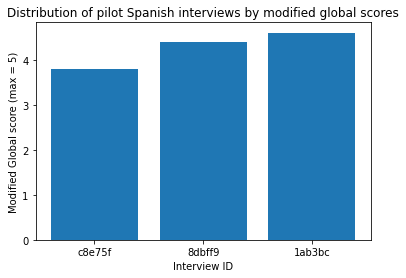

   modified_global_score                        interview_ID
0                    3.8  RE0fb9df1929fea1d6cf799da7b0c8e75f
1                    4.4  RE52eab732878d5d9928f284a2e48dbff9
2                    4.6  RE2f7e16e1c93e2aaafa6f4428ab1ab3bc


<Figure size 432x288 with 0 Axes>

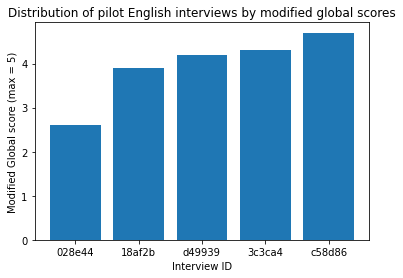

   modified_global_score                        interview_ID
0                    2.6  RE1f175cf47d8bc64eba9b21aaec028e44
1                    3.9  RE2cddbcf83b4b27e538e185a04a18af2b
2                    4.2  RE13969403f5a37da7308bac270bd49939
3                    4.3  REad702d81cc4b7d93c14c6227373c3ca4
4                    4.7  RE2b76dfe070a66d596af4667972c58d86


<Figure size 432x288 with 0 Axes>

In [16]:
# Show distribution in Spanish and English pilot interviews

_ = plt.figure(figsize=(6,4))
_ = plt.bar(pilot_global_scores_df_es["interview_ID"].map(lambda intid: intid[-6:]),
            pilot_global_scores_df_es["modified_global_score"])
_ = plt.xlabel('Interview ID')
_ = plt.ylabel('Modified Global score (max = 5)')
_ = plt.title(f"Distribution of pilot Spanish interviews by modified global scores")
plt.show()
plt.clf()
print(pilot_global_scores_df_es)


_ = plt.figure(figsize=(6,4))
_ = plt.bar(pilot_global_scores_df_en["interview_ID"].map(lambda intid: intid[-6:]),
            pilot_global_scores_df_en["modified_global_score"])
_ = plt.xlabel('Interview ID')
_ = plt.ylabel('Modified Global score (max = 5)')
_ = plt.title(f"Distribution of pilot English interviews by modified global scores")
plt.show()
plt.clf()
print(pilot_global_scores_df_en)


In [17]:
# Add participant IDs and demographic background information to English calls

# English pilot calls require two steps: 1 Add participant IDs ['sid'],
pilot_merged_df_en = pd.merge(pilot_global_scores_df_en,
                              info_call_part_df, how ='inner', on =['interview_ID'])

# 2: Use participant IDs to add "education", "ethnicity", "race", "age" from background_info_df

columns = ["sid", "education", "ethnicity", "race", "age"]
background_part_edu_eth_race_age_df = background_info_df.loc[1:,columns]

pilot_full_df_en = pd.merge(pilot_merged_df_en,
                 background_part_edu_eth_race_age_df, how ='inner', on =['sid'])

# Make sure we actually have all interviews
for interview in pilot_interviews_en:
    try:
        assert interview in set(pilot_full_df_en['interview_ID'])
    except AssertionError as e:
        print(f"*** Missing interview or participant ID in English df ***\n\
        {pilot_merged_df_en.set_index('interview_ID', inplace = False).loc[interview]}")

pilot_full_df_en

*** Missing interview or participant ID in English df ***
        modified_global_score             3.9
sid                      039-0225-009
Name: RE2cddbcf83b4b27e538e185a04a18af2b, dtype: object


,modified_global_score,interview_ID,sid,education,ethnicity,race,age
0,2.6,RE1f175cf47d8bc64eba9b21aaec028e44,202-0225-001,6.0,2.0,5.0,49.905544
1,4.2,RE13969403f5a37da7308bac270bd49939,154-0225-006,6.0,1.0,5.0,65.859001
2,4.3,REad702d81cc4b7d93c14c6227373c3ca4,083-0225-064,6.0,1.0,5.0,57.691990
3,4.7,RE2b76dfe070a66d596af4667972c58d86,852-0225-005,5.0,2.0,5.0,71.162216


**Issue with interview ID RE2cddbcf83b4b27e538e185a04a18af2b**

- I checked manually inside the `LIVES_Outcome_Data_BL-24M_ppts_from_fidelity_list_n=173_trimmed.xlsx` file and it seems that the participant ID for this interview (`039-0225-009`) is not there.
- Sarah advised to check the `LIVES_BehaviorOutcomes_BL-24M_01062021_ALL PARTICIPANTS.xls` file, but there is also no information about this participant.
- The decision between Sarah and myself is to discard this interview. Only 5 minutes of it had been annotated and diarized for the piot, so we thought it was fine.

In [18]:
# Add participant IDs and demographic background information to Spanish calls

# Spanish pilot calls require only one step:
# Use participant IDs to add "education", "ethnicity", "race", "age" from background_info_df
columns = ["sid", "education", "ethnicity", "race", "age", "interview_ID"]
background_part_edu_eth_race_age_df = background_info_df_lat.loc[1:,columns]

pilot_full_df_es = pd.merge(pilot_global_scores_df_es,
                              background_part_edu_eth_race_age_df, how ='inner', on =['interview_ID'])

# Make sure we actually have all interviews
for interview in pilot_interviews_es:
    try:
        assert interview in set(pilot_full_df_es['interview_ID'])
    except AssertionError as e:
        print(f"*** Missing interview or participant ID in Spanish df ***\n\
        {pilot_full_df_es.set_index('interview_ID', inplace = False).loc[interview]}")

pilot_full_df_es

,modified_global_score,interview_ID,sid,education,ethnicity,race,age
0,3.8,RE0fb9df1929fea1d6cf799da7b0c8e75f,177-0225-001,3,2,6.0,43.728954
1,4.4,RE52eab732878d5d9928f284a2e48dbff9,022-0225-015,4,2,NaN,68.490074
2,4.6,RE2f7e16e1c93e2aaafa6f4428ab1ab3bc,078-0225-004,5,2,6.0,51.676933


## IV Create interview dataframes 

Create a data frame for each of the following:

- non_latinas_interviews_df
- latinas_en_interviews_df
- latinas_es_interviews_df

Steps:

1. Subtract pilot interviews from `info_call_part_global_df`
2. Add backgound info from:
    - non_latinas_df
    - latinas_en_df
    - latinas_es_df


In [19]:
# Subtract pilot interviews
difference = set(info_call_part_global_df['interview_ID']) - set(pilot_full_df_en['interview_ID'])\
             - set(pilot_full_df_es['interview_ID'])

info_call_part_global_diff_df = info_call_part_global_df[pd.DataFrame(info_call_part_global_df.interview_ID.to_list())\
                                               .isin(difference).any(1).values]

len(info_call_part_global_diff_df) # previous = 308, now = 316

# Make sure the pilot interviews are not in the info_call_part_global_diff_df
for interview in info_call_part_global_diff_df['interview_ID']:
    try:
        assert not interview in set(pilot_full_df_en['interview_ID'])
    except AssertionError as e:
        print(f"interview {interview}")

In [20]:
# Add background info based on sid

columns = ["sid", "education", "ethnicity", "race", "age"]

non_latinas_interviews_df = pd.merge(info_call_part_global_diff_df,
                              non_latinas_df.loc[1:,columns], how ='inner', on =['sid'])

latinas_en_interviews_df = pd.merge(info_call_part_global_diff_df,
                              latinas_en_df.loc[1:,columns], how ='inner', on =['sid'])

latinas_es_interviews_df = pd.merge(latinas_es_df.loc[1:,columns],
                                    pilot_full_df_es, how ='left', on =['sid'])

difference = set(latinas_es_df.sid) - set(pilot_full_df_es.sid)
latinas_es_interviews_df = latinas_es_df[pd.DataFrame(latinas_es_df.sid.to_list())\
                                               .isin(difference).any(1).values]

**Resulting Dataframes**

In [21]:
print("\n\n***Non-Latina participant interviews with background information`:\n\n",
non_latinas_interviews_df.head(3))

print("\n\n***English-speaking Latina participant interviews with background information`:\n\n",
latinas_en_interviews_df.head(3))

print("\n\n***Spanish-speaking Latina participant interviews with background information`:\n\n",
latinas_es_interviews_df.head(3))




***Non-Latina participant interviews with background information`:

                          interview_ID           sid  global_spirit_rating  \
0  RE4956387b8e3f52203180d3d17d2ee61a  821-0225-009              3.666667   
1  RE104522f119f340187cdb416bd2591a79  866-0225-015              4.333333   
2  RE84ef2254720e73e42e84b5df692052f6  866-0225-015              4.000000   

   education  ethnicity  race        age  
0        6.0        1.0   5.0  70.579056  
1        4.0        1.0   5.0  65.278580  
2        4.0        1.0   5.0  65.278580  


***English-speaking Latina participant interviews with background information`:

                          interview_ID           sid  global_spirit_rating  \
0  RE6ab74e952649f2d6f54842e7b0d07929  854-0225-005              4.000000   
1  REe9ea55afdc95f287bd95467f6f714935  854-0225-005              3.666667   
2  REfaca85668e11be51c3208b68fcb98742  838-0225-001              4.333333   

  education  ethnicity  race        age  
0       6.0  

## V. Sampling the English dataset by global rating

Total sampled English calls should be (n=30) plus the ones we already sampled from the pilot (4 or 5):
- 35 interviews x 2 annotators | 1 week x annotator = 18 weeks: Nov - May (taking into account holidays etc)
- Sample the first half with non-Latinas' interviews and second half with English-speaking Latinas' interviews

In [22]:
# Descriptions
def print_description(pdf:pd.DataFrame,
                      description: str,
                      global_rates:bool = True,
                      education:bool = True,
                      age:bool = True,
                      race:bool = True,
                      test:bool = False,
                      verbose: bool=False):

    print(f"\n\n*** {description} ***")

    if verbose:
        print(f"- Dataframe description:\n",
              pdf.describe())

    print(f"\n- No. of enries in your DataFrame: {len(pdf.index)}")

    if global_rates:
        global_scores = [x for x in sorted(set(pdf['global_spirit_rating'])) if np.isnan(x) == False]
        print(f"- No. of different MITI modified scores: {pdf['global_spirit_rating'].nunique()}, ",
              f"Global scores: {global_scores}")

    if education:
        education = [x for x in sorted(set(pdf['education'])) if np.isnan(x) == False]
        print(f"- No. of different education backgrounds: {pdf['education'].nunique()}, ",
              f"Education backgrounds: {education}")

    if age:
        age = [x for x in sorted(set(pdf['age'])) if np.isnan(x) == False]
        print(f"- No. of different ages: {pdf['age'].nunique()}, ",
              f"Ages range: {age[0]}... {age[-1]}")

    if race:
        race = [x for x in sorted(set(pdf['race'])) if np.isnan(x) == False]
        print(f"- No. of different races: {pdf['race'].nunique()}, ",
              f"Races: {race}")

    # Test for repeated participant IDs and interview IDs. Useful set comprehension taken from:
    # https://stackoverflow.com/questions/9835762/how-do-i-find-the-duplicates-in-a-list-and-create-another-list-with-them
    if test:
        seen = set()
        duplicates = set(x for x in list(pdf['sid']) if x in seen or seen.add(x))
        n_repeated = len(duplicates)
        try:
            assert n_repeated == 0
        except:
            print(f"- >>> There are {n_repeated} participant IDs repeated in your sample: ***\n",
                 duplicates)

        seen = set()
        duplicates = set(x for x in list(pdf['interview_ID']) if x in seen or seen.add(x))
        n_repeated = len(duplicates)
        try:
            assert n_repeated == 0
        except:
            print(f"- >>> There are {n_repeated} interview IDs repeated in your sample: ***\n",
                 duplicates)

In [23]:
# Plots
def plot_global_education_age(pdf: pd.DataFrame,
                              description:str,
                              global_rates:bool = True,
                              education:bool = True,
                              race:bool = True,
                              age:bool = True):

    if global_rates:
        sorted_pdf = pdf.sort_values('global_spirit_rating')
        _ = plt.figure(figsize=(8,4))
        _ = plt.hist(sorted_pdf['global_spirit_rating'])
        _ = plt.xlabel('modified global score (max = 5)')
        _ = plt.ylabel('number of interviews')
        _ = plt.title(f"{description} by modified global scores")
        plt.show()

    if education:
        sorted_pdf = pdf.sort_values('education')
        _ = plt.figure(figsize=(8,4))
        _ = plt.hist([str(int(x)) for x in sorted_pdf['education']])
        _ = plt.xlabel('education')
        _ = plt.ylabel('number of interviews')
        _ = plt.title(f"{description} by education")
        plt.show()

    if age:
        sorted_pdf = pdf.sort_values('age')
        _ = plt.figure(figsize=(8,4))
        _ = plt.hist([str(int(x)) for x in sorted_pdf['age']])
        _ = plt.xlabel('age')
        _ = plt.ylabel('number of interviews')
        _ = plt.title(f"{description} by age")
        plt.show()
        
    if race:
        sorted_pdf = pdf.sort_values('race')
        _ = plt.figure(figsize=(8,4))
        _ = plt.hist([str(int(x)) for x in sorted_pdf['race']])
        _ = plt.xlabel('race')
        _ = plt.ylabel('number of interviews')
        _ = plt.title(f"{description} by race")
        plt.show()

In [24]:
# Stratified random sampling based on https://www.statology.org/stratified-sampling-pandas/

# I am not sure how to apply the new seeding method so I have this
np.random.seed(35)

def stat_random_sample(sample_size:int,
                       str_df:pd.DataFrame,
                       group_cols:list) -> pd.DataFrame:

    return str_df.groupby(group_cols, group_keys=False)\
                .apply(lambda x: x.sample(int(np.rint(sample_size*len(x)/len(str_df)))))\
                .sample(frac=1).reset_index(drop=True)

**Non-Latina pool of interviews: plots and sampling by global rating**



*** Pool of non-Latina interviews ***
- Dataframe description:
        global_spirit_rating   education  ethnicity        race         age
count            282.000000  273.000000      273.0  273.000000  277.000000
mean               4.147754    5.527473        1.0    4.750916   59.420099
std                0.260480    0.696747        0.0    0.740286   14.038237
min                3.000000    3.000000        1.0    2.000000   33.051334
25%                4.000000    5.000000        1.0    5.000000   51.348392
50%                4.000000    6.000000        1.0    5.000000   58.151951
75%                4.333333    6.000000        1.0    5.000000   65.278580
max                5.000000    6.000000        1.0    5.000000  148.900757

- No. of enries in your DataFrame: 282
- No. of different MITI modified scores: 7,  Global scores: [3.0, 3.3333332538604736, 3.6666667461395264, 4.0, 4.333333492279053, 4.666666507720947, 5.0]
- No. of different education backgrounds: 4,  Education backgroun

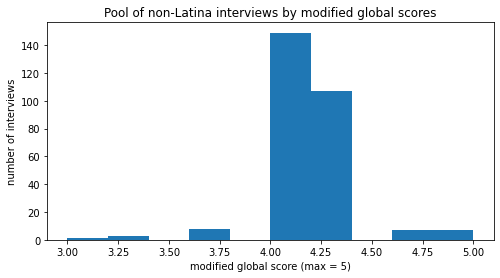

In [25]:
# Let's look at the full set of interviews. 

print_description(non_latinas_interviews_df, "Pool of non-Latina interviews", verbose=True)

non_latinas_interviews_df_sorted = non_latinas_interviews_df.sort_values('global_spirit_rating')
_ = plt.figure(figsize=(8,4))
_ = plt.hist(non_latinas_interviews_df_sorted['global_spirit_rating'])
_ = plt.xlabel('modified global score (max = 5)')
_ = plt.ylabel('number of interviews')
_ = plt.title(f"Pool of non-Latina interviews by modified global scores")
plt.show()

In [26]:
# Get the lowes and highest global spirit ratings based on mean and standard dev
global_rating_mean = non_latinas_interviews_df_sorted['global_spirit_rating'].mean()
global_rating_std = non_latinas_interviews_df_sorted['global_spirit_rating'].std()

high_scores = non_latinas_interviews_df[non_latinas_interviews_df["global_spirit_rating"]\
                              > (global_rating_mean + global_rating_std)]


low_scores = non_latinas_interviews_df[non_latinas_interviews_df["global_spirit_rating"]\
                              < (global_rating_mean - global_rating_std)]


intermediate_scores = pd.concat([non_latinas_interviews_df,
                                 high_scores,
                                 low_scores]).drop_duplicates(keep=False)


# Check that we're not oversampling or undersampling
assert len(pd.concat([non_latinas_interviews_df,
                      high_scores,
                      low_scores,
                      intermediate_scores]).drop_duplicates(keep=False)) == 0


In [27]:
# Describe the datasets
print_description(high_scores, "High-scored non_Latina interviews")
print_description(intermediate_scores, "Intermediate-scored non_Latina interviews")
print_description(low_scores, "Low-scored non_Latina interviews")



*** High-scored non_Latina interviews ***

- No. of enries in your DataFrame: 14
- No. of different MITI modified scores: 2,  Global scores: [4.666666507720947, 5.0]
- No. of different education backgrounds: 3,  Education backgrounds: [4.0, 5.0, 6.0]
- No. of different ages: 14,  Ages range: 34.26420211791992... 85.9822006225586
- No. of different races: 1,  Races: [5.0]


*** Intermediate-scored non_Latina interviews ***

- No. of enries in your DataFrame: 256
- No. of different MITI modified scores: 2,  Global scores: [4.0, 4.333333492279053]
- No. of different education backgrounds: 4,  Education backgrounds: [3.0, 4.0, 5.0, 6.0]
- No. of different ages: 133,  Ages range: 33.051334381103516... 148.9007568359375
- No. of different races: 3,  Races: [2.0, 3.0, 5.0]


*** Low-scored non_Latina interviews ***

- No. of enries in your DataFrame: 12
- No. of different MITI modified scores: 3,  Global scores: [3.0, 3.3333332538604736, 3.6666667461395264]
- No. of different education back

In [28]:
# Get ~5 stratified samples of interviews from each batch of scores taking into account education and race

# I changed this sample from 5 to 6 items to match the number of Engish-speaking latinas (18, below)
stratified_high_scores = stat_random_sample(sample_size=6,
                                            str_df=high_scores,
                                            group_cols=['education','race'])

stratified_intermediate_scores = stat_random_sample(sample_size=5,
                                                    str_df=intermediate_scores,
                                                    group_cols=['education','race'])

stratified_low_scores = stat_random_sample(sample_size=5,
                                           str_df=low_scores,
                                           group_cols=['education','race'])


print_description(stratified_high_scores, "stratified_high_scores")
print_description(stratified_intermediate_scores, "stratified_intermediate_scores")
print_description(stratified_low_scores, "stratified_low_scores")



*** stratified_high_scores ***

- No. of enries in your DataFrame: 6
- No. of different MITI modified scores: 2,  Global scores: [4.666666507720947, 5.0]
- No. of different education backgrounds: 3,  Education backgrounds: [4.0, 5.0, 6.0]
- No. of different ages: 6,  Ages range: 45.122520446777344... 64.20259857177734
- No. of different races: 1,  Races: [5.0]


*** stratified_intermediate_scores ***

- No. of enries in your DataFrame: 4
- No. of different MITI modified scores: 2,  Global scores: [4.0, 4.333333492279053]
- No. of different education backgrounds: 2,  Education backgrounds: [5.0, 6.0]
- No. of different ages: 4,  Ages range: 34.26420211791992... 82.46954345703125
- No. of different races: 1,  Races: [5.0]


*** stratified_low_scores ***

- No. of enries in your DataFrame: 4
- No. of different MITI modified scores: 1,  Global scores: [3.6666667461395264]
- No. of different education backgrounds: 2,  Education backgrounds: [4.0, 6.0]
- No. of different ages: 4,  Ages ran

In [29]:
# Look at the non-Latina interviews we have in the pilot so that we can balance the sample
std_pilot_columns = ['global_spirit_rating', 'interview_ID', 'sid', 'education', 'ethnicity', 'race', 'age']
non_Latinas_in_pilot = pilot_full_df_en[pilot_full_df_en['ethnicity'] == 1]

# Rename colums to match our other other dataframes
non_Latinas_in_pilot.columns = std_pilot_columns

print("\n\n*** non-Latina interviews in pilot ***\n",
      non_Latinas_in_pilot)  # education 6 and race 5, scores [4.2, 4.3]



*** non-Latina interviews in pilot ***
    global_spirit_rating                        interview_ID           sid  \
1                   4.2  RE13969403f5a37da7308bac270bd49939  154-0225-006   
2                   4.3  REad702d81cc4b7d93c14c6227373c3ca4  083-0225-064   

   education  ethnicity  race        age  
1        6.0        1.0   5.0  65.859001  
2        6.0        1.0   5.0  57.691990  


In [30]:
# It seems like we have two with an intermediate global score already
# Let's add to our sample interviews from the lowest category to try and balance the sample.
# We always want more low-scred interviews because the sample is skewed towards "good" interviews

sample_size = 6
stratified_low_scores = low_scores.groupby(['education','race'], group_keys=False)\
.apply(lambda x: x.sample(int(np.rint(sample_size*len(x)/len(low_scores)))))\
.sample(frac=1).reset_index(drop=True)

print_description(stratified_low_scores, "stratified_low_scores")



*** stratified_low_scores ***

- No. of enries in your DataFrame: 6
- No. of different MITI modified scores: 2,  Global scores: [3.3333332538604736, 3.6666667461395264]
- No. of different education backgrounds: 2,  Education backgrounds: [4.0, 6.0]
- No. of different ages: 6,  Ages range: 48.84599685668945... 78.28337097167969
- No. of different races: 2,  Races: [3.0, 5.0]


In [31]:
# Put everything together
sampled_non_latinas_interviews_no_pilot = pd.concat([stratified_high_scores, stratified_low_scores,
                                             stratified_intermediate_scores]).drop_duplicates(keep='first')


sampled_non_latinas_interviews_full = pd.concat([sampled_non_latinas_interviews_no_pilot,
                                                 non_Latinas_in_pilot]).drop_duplicates(keep='first')


print_description(sampled_non_latinas_interviews_full, "sampled_non_latinas_interviews_full",
                  verbose=True,
                  test=True)



*** sampled_non_latinas_interviews_full ***
- Dataframe description:
        global_spirit_rating  education  ethnicity       race        age
count             18.000000  18.000000       18.0  18.000000  18.000000
mean               4.212963   5.500000        1.0   4.777778  58.872462
std                0.581989   0.785905        0.0   0.646762  12.109397
min                3.333333   4.000000        1.0   3.000000  34.264202
25%                3.666667   5.000000        1.0   5.000000  51.785077
50%                4.250000   6.000000        1.0   5.000000  55.366186
75%                4.666667   6.000000        1.0   5.000000  65.713896
max                5.000000   6.000000        1.0   5.000000  82.469543

- No. of enries in your DataFrame: 18
- No. of different MITI modified scores: 8,  Global scores: [3.3333332538604736, 3.6666667461395264, 4.0, 4.2, 4.3, 4.333333492279053, 4.666666507720947, 5.0]
- No. of different education backgrounds: 3,  Education backgrounds: [4.0, 5.0, 6.

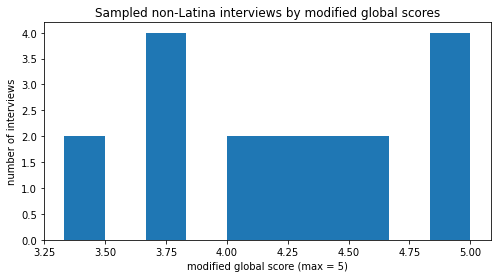

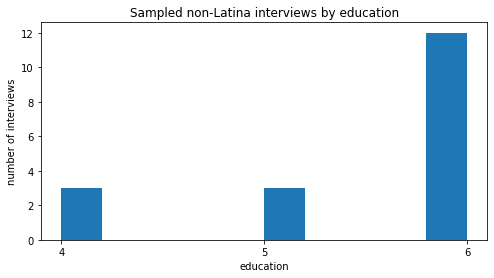

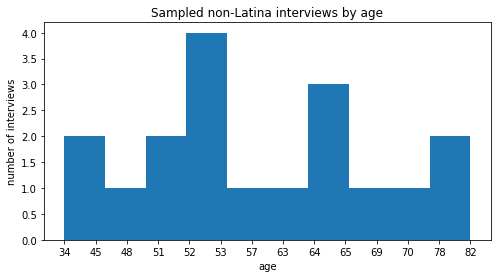

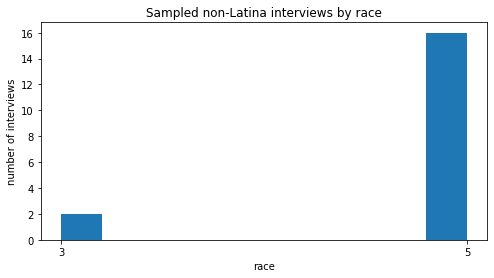

In [32]:
plot_global_education_age(sampled_non_latinas_interviews_full, "Sampled non-Latina interviews")

**English-speaking Latina pool of interviews: plots and sampling by global rating**



*** Pool of English-speaking Latina interviews ***
- Dataframe description:
        global_spirit_rating   education  ethnicity        race         age
count            282.000000  273.000000      273.0  273.000000  277.000000
mean               4.147754    5.527473        1.0    4.750916   59.420099
std                0.260480    0.696747        0.0    0.740286   14.038237
min                3.000000    3.000000        1.0    2.000000   33.051334
25%                4.000000    5.000000        1.0    5.000000   51.348392
50%                4.000000    6.000000        1.0    5.000000   58.151951
75%                4.333333    6.000000        1.0    5.000000   65.278580
max                5.000000    6.000000        1.0    5.000000  148.900757

- No. of enries in your DataFrame: 282
- No. of different MITI modified scores: 7,  Global scores: [3.0, 3.3333332538604736, 3.6666667461395264, 4.0, 4.333333492279053, 4.666666507720947, 5.0]
- No. of different education backgrounds: 4,  Educat

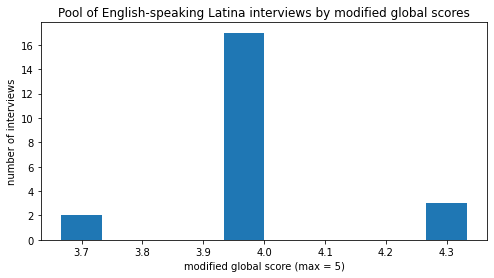

In [33]:
# Let's look at the full set of interviews. 

print_description(non_latinas_interviews_df, "Pool of English-speaking Latina interviews", verbose=True)
# print(f"The English-speaking Latinas pool contains n={len(latinas_en_interviews_df)} interviews. This is the description:\n")

latinas_en_interviews_df_sorted = latinas_en_interviews_df.sort_values('global_spirit_rating')
_ = plt.figure(figsize=(8,4))
_ = plt.hist(latinas_en_interviews_df_sorted['global_spirit_rating'])
_ = plt.xlabel('modified global score (max = 5)')
_ = plt.ylabel('number of interviews')
_ = plt.title(f"Pool of English-speaking Latina interviews by modified global scores")
plt.show()

In [34]:
# Get the lowest and highest global spirit ratings based on mean and standard dev
global_rating_mean = latinas_en_interviews_df['global_spirit_rating'].mean()
global_rating_std = latinas_en_interviews_df['global_spirit_rating'].std()

high_scores = latinas_en_interviews_df[latinas_en_interviews_df["global_spirit_rating"]\
                              > (global_rating_mean + global_rating_std)]


low_scores = latinas_en_interviews_df[latinas_en_interviews_df["global_spirit_rating"]\
                              < (global_rating_mean - global_rating_std)]


intermediate_scores = pd.concat([latinas_en_interviews_df,
                                 high_scores,
                                 low_scores]).drop_duplicates(keep=False)

# Check that we're not oversampling or undersampling
assert len(pd.concat([latinas_en_interviews_df,
                      high_scores,
                      low_scores,
                      intermediate_scores]).drop_duplicates(keep=False)) == 0

In [35]:
# Describe the datasets
print_description(high_scores, "High-scored non_Latina interviews")
print_description(intermediate_scores, "Intermediate-scored non_Latina interviews")
print_description(low_scores, "Low-scored non_Latina interviews")



*** High-scored non_Latina interviews ***

- No. of enries in your DataFrame: 3
- No. of different MITI modified scores: 1,  Global scores: [4.333333492279053]
- No. of different education backgrounds: 2,  Education backgrounds: [5.0, 6.0]
- No. of different ages: 3,  Ages range: 42.877479553222656... 59.81930160522461
- No. of different races: 1,  Races: [5.0]


*** Intermediate-scored non_Latina interviews ***

- No. of enries in your DataFrame: 17
- No. of different MITI modified scores: 1,  Global scores: [4.0]
- No. of different education backgrounds: 3,  Education backgrounds: [4.0, 5.0, 6.0]
- No. of different ages: 15,  Ages range: 33.15263366699219... 67.32101440429688
- No. of different races: 4,  Races: [3.0, 4.0, 5.0, 6.0]


*** Low-scored non_Latina interviews ***

- No. of enries in your DataFrame: 2
- No. of different MITI modified scores: 1,  Global scores: [3.6666667461395264]
- No. of different education backgrounds: 2,  Education backgrounds: [5.0, 6.0]
- No. of di

In [36]:
# Since there are so few interviews, we can get away with only stratified random sampling for intermediate scores.
# Let's first try and see what we had from the pilot:

# Look at the English-speaking Latina interviews we have in the pilot so that we can balance the sample
std_pilot_columns = ['global_spirit_rating', 'interview_ID', 'sid', 'education', 'ethnicity', 'race', 'age']
en_speaking_Latinas_in_pilot = pilot_full_df_en[pilot_full_df_en['ethnicity'] == 2]

# Rename colums to match our other other dataframes
en_speaking_Latinas_in_pilot.columns = std_pilot_columns

print("\n\n*** English-speaking Latinas' interviews in pilot ***\n",
      en_speaking_Latinas_in_pilot)  # education 6 and race 5, scores [4.2, 4.3]



*** English-speaking Latinas' interviews in pilot ***
    global_spirit_rating                        interview_ID           sid  \
0                   2.6  RE1f175cf47d8bc64eba9b21aaec028e44  202-0225-001   
3                   4.7  RE2b76dfe070a66d596af4667972c58d86  852-0225-005   

   education  ethnicity  race        age  
0        6.0        2.0   5.0  49.905544  
3        5.0        2.0   5.0  71.162216  


In [37]:
# So this is what we have so far:
# 3 High-scored from the interview pool
# 2 Low-scored from the interview pool
# 1 Low-scored from the pilot
# 1 Intermediate-scored from the pilot
# We'll need 10 more interviews to match the 17 non-Latina interviews for the English interview pool

stratified_intermediate_scores = stat_random_sample(sample_size=10,
                                                    str_df=intermediate_scores,
                                                    group_cols=['global_spirit_rating','education','race'])

print_description(stratified_intermediate_scores, "Intermediate-scored non_Latina interviews")



*** Intermediate-scored non_Latina interviews ***

- No. of enries in your DataFrame: 11
- No. of different MITI modified scores: 1,  Global scores: [4.0]
- No. of different education backgrounds: 3,  Education backgrounds: [4.0, 5.0, 6.0]
- No. of different ages: 11,  Ages range: 33.15263366699219... 67.32101440429688
- No. of different races: 4,  Races: [3.0, 4.0, 5.0, 6.0]


In [38]:
# Put everything together
sampled_en_latinas_interviews_no_pilot = pd.concat([high_scores, low_scores,
                                             stratified_intermediate_scores]).drop_duplicates(keep='first')


sampled_en_latinas_interviews_full = pd.concat([sampled_en_latinas_interviews_no_pilot,
                                                 en_speaking_Latinas_in_pilot]).drop_duplicates(keep='first')


print_description(sampled_en_latinas_interviews_full, "sampled_en_latinas_interviews_no_pilot",
                  verbose=True, test=True)



*** sampled_en_latinas_interviews_no_pilot ***
- Dataframe description:
        global_spirit_rating  ethnicity       race        age
count              18.00000       18.0  18.000000  18.000000
mean                3.97963        2.0   4.944444  50.762035
std                 0.41995        0.0   0.725358   9.625086
min                 2.60000        2.0   3.000000  33.152634
25%                 4.00000        2.0   5.000000  44.221080
50%                 4.00000        2.0   5.000000  48.010952
75%                 4.00000        2.0   5.000000  57.757016
max                 4.70000        2.0   6.000000  71.162216

- No. of enries in your DataFrame: 18
- No. of different MITI modified scores: 5,  Global scores: [2.6, 3.6666667461395264, 4.0, 4.333333492279053, 4.7]
- No. of different education backgrounds: 3,  Education backgrounds: [4.0, 5.0, 6.0]
- No. of different ages: 14,  Ages range: 33.15263366699219... 71.16221618652344
- No. of different races: 4,  Races: [3.0, 4.0, 5.0, 6.0

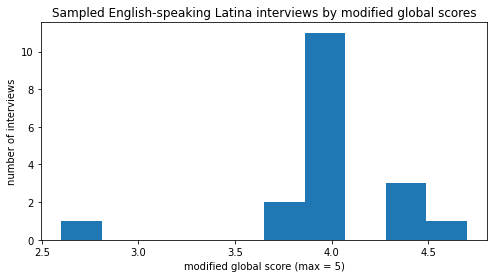

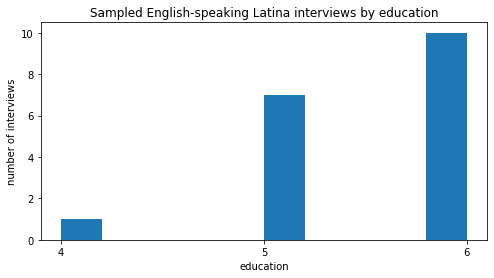

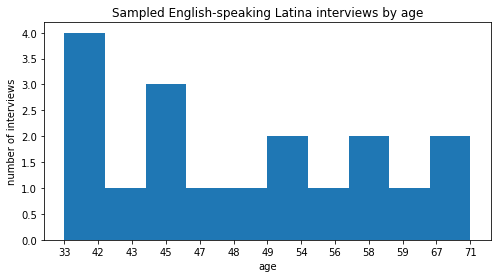

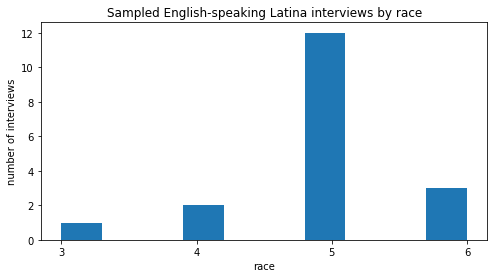

In [39]:
plot_global_education_age(sampled_en_latinas_interviews_full, "Sampled English-speaking Latina interviews")

**Create English-speaking interview sample for annotation**

In [40]:
# Concatenate English-speaking Latinas and non-Latina participants and show distributions
english_interview_sample_for_annotation = pd.concat([sampled_non_latinas_interviews_full,
                                                    sampled_en_latinas_interviews_full,])

print(f"\n*** Number of sampled English (Lat and non-Lat) interviews: {len(english_interview_sample_for_annotation)} ***")

print_description(english_interview_sample_for_annotation,"Full English interview sample for annotation",
                  verbose=True, test=True)


*** Number of sampled English (Lat and non-Lat) interviews: 36 ***


*** Full English interview sample for annotation ***
- Dataframe description:
        global_spirit_rating  ethnicity       race        age
count             36.000000  36.000000  36.000000  36.000000
mean               4.096296   1.500000   4.861111  54.817248
std                0.513981   0.507093   0.682549  11.538467
min                2.600000   1.000000   3.000000  33.152634
25%                3.916667   1.000000   5.000000  45.707733
50%                4.000000   1.500000   5.000000  52.731007
75%                4.333333   2.000000   5.000000  63.436686
max                5.000000   2.000000   6.000000  82.469543

- No. of enries in your DataFrame: 36
- No. of different MITI modified scores: 10,  Global scores: [2.6, 3.3333332538604736, 3.6666667461395264, 4.0, 4.2, 4.3, 4.333333492279053, 4.666666507720947, 4.7, 5.0]
- No. of different education backgrounds: 3,  Education backgrounds: [4.0, 5.0, 6.0]
- No. of

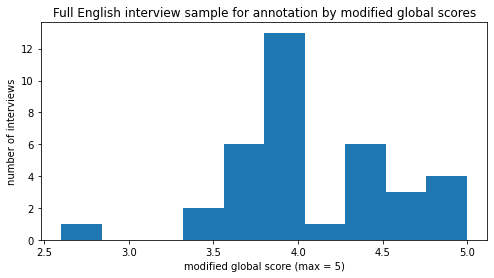

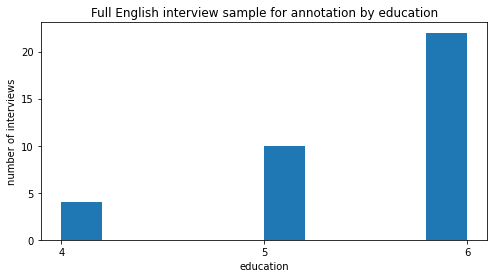

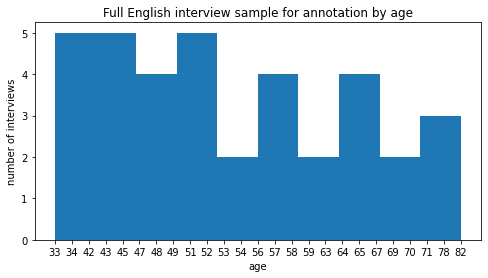

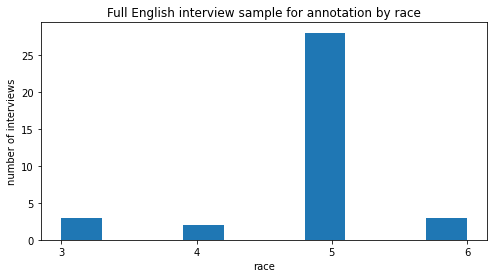

In [41]:
plot_global_education_age(english_interview_sample_for_annotation, "Full English interview sample for annotation")

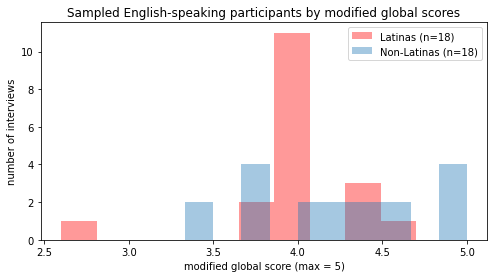

In [42]:
english_interview_sample_for_annotation_sorted = english_interview_sample_for_annotation.sort_values('global_spirit_rating')

# Distribution of Latinas and non-Latinas in the sampled dataset
lat = english_interview_sample_for_annotation_sorted\
      [english_interview_sample_for_annotation_sorted['ethnicity'] == 2]

non_lat = english_interview_sample_for_annotation_sorted\
          [english_interview_sample_for_annotation_sorted['ethnicity'] == 1]

_ = plt.figure(figsize=(8,4))
_ = plt.hist(lat['global_spirit_rating'], alpha=0.4, color='red')
_ = plt.hist(non_lat['global_spirit_rating'], alpha=0.4)
_ = plt.xlabel('modified global score (max = 5)')
_ = plt.ylabel('number of interviews')
_ = plt.title(f"Sampled English-speaking participants by modified global scores")
plt.legend([f"Latinas (n={len(lat.index)})", f"Non-Latinas (n={len(non_lat.index)})"])
plt.show()

## VI. Sampling the Spanish dataset by global rating

Total sampled English calls should be (n=30) plus the ones we already sampled from the pilot (3):
- We want at least 5 to be from the same participant for a case study (Alexandra still needs to tell me who this is)
- 35 interviews x 2 annotators | 1 week x annotator = 18 weeks: Nov - May (taking into account holidays etc)
- Sample the first half with non-Latinas' interviews and second half with English-speaking Latinas' interviews

In [43]:
# Let's look at the full set of participants 
# Remember this time we won't have interview information

# The education column is a mix of types. We need to change that
education_replace = []
for x in list(latinas_es_df['education']):
    if isinstance(x, str):
        education_replace.append(0) # Zero will mean "no education background"
    elif isinstance(x, int):
        education_replace.append(x)

latinas_es_df['education'] = education_replace

race_replace = []

# The race column contains NaN values. We need to change that
import math
race_replace = []
for x in list(latinas_es_df['race']):
    if math.isnan(x):
        race_replace.append(0) # Zero will mean "no education background"
    else:
        race_replace.append(x)

latinas_es_df['race'] = race_replace


# latinas_es_df['education'] = [str(x) for x in list(latinas_es_df['education'])]
print_description(latinas_es_df, "Spanish-speaking Latina participant pool",
                  verbose=True, global_rates=False)



*** Spanish-speaking Latina participant pool ***
- Dataframe description:
        education  ethnicity      race        age    # calls
count  10.000000       10.0  10.00000  10.000000  10.000000
mean    2.600000        2.0   4.80000  54.436140  18.200000
std     1.712698        0.0   1.75119   9.426445  12.299955
min     0.000000        2.0   0.00000  41.040382   3.000000
25%     2.000000        2.0   5.00000  47.988364   6.000000
50%     2.500000        2.0   5.00000  52.391512  18.000000
75%     4.000000        2.0   5.75000  61.250514  30.500000
max     5.000000        2.0   6.00000  68.490074  33.000000

- No. of enries in your DataFrame: 10
- No. of different education backgrounds: 5,  Education backgrounds: [0, 2, 3, 4, 5]
- No. of different ages: 10,  Ages range: 41.040382385253906... 68.49007415771484
- No. of different races: 3,  Races: [0.0, 5.0, 6.0]


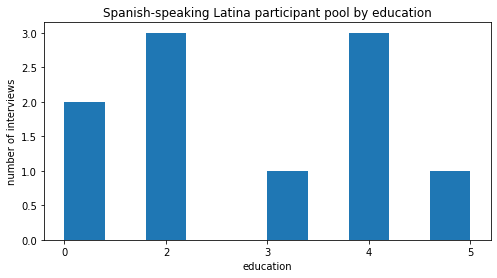

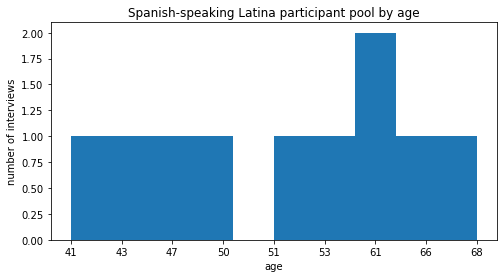

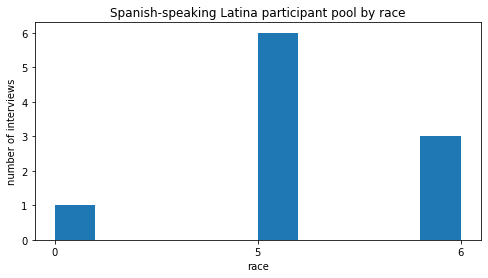

In [44]:
plot_global_education_age(latinas_es_df, "Spanish-speaking Latina participant pool", global_rates=False)

In [45]:
# In order to sample calls from this participant pool, we'll extend this dataframe
# Using the '# calls' column, then randomize from there based on call number SID_callNo

sid = latinas_es_df['sid']
edu = latinas_es_df['education']
age = latinas_es_df['age']
ethnicity = latinas_es_df['ethnicity']
race = latinas_es_df['race']
age = latinas_es_df['age']

my_dict = {'sid':[],'education':[],'age':[], 'interview_ID':[],
           'ethnicity':[],'race':[]}

for i,j in enumerate(latinas_es_df['# calls']):
    for n in range(int(j)):
        # print(sid.iloc[i], f"call_no_{n+1}", edu.iloc[i], age.iloc[i])

        my_dict['sid'].append(sid.iloc[i])
        my_dict['education'].append(edu.iloc[i])
        my_dict['interview_ID'].append(f"{sid.iloc[i]}_call_no_{n+1}") # We made these up to extend the dataset
        my_dict['ethnicity'].append(ethnicity.iloc[i])
        my_dict['race'].append(race.iloc[i])
        my_dict['age'].append(age.iloc[i])

# latinas_es_df.groupby(['# calls','sid']).count()
extended_latinas_es_df = pd.DataFrame(my_dict)

In [46]:
print_description(extended_latinas_es_df, "Full Spanish interview sample for annotation",
                  verbose=True, global_rates=False, test=True)



*** Full Spanish interview sample for annotation ***
- Dataframe description:
         education         age  ethnicity        race
count  182.000000  182.000000      182.0  182.000000
mean     2.230769   54.766463        2.0    5.082418
std      1.615374    9.148686        0.0    0.951195
min      0.000000   41.040382        2.0    0.000000
25%      0.000000   50.540726        2.0    5.000000
50%      2.000000   53.106091        2.0    5.000000
75%      4.000000   61.273102        2.0    5.000000
max      5.000000   68.490074        2.0    6.000000

- No. of enries in your DataFrame: 182
- No. of different education backgrounds: 5,  Education backgrounds: [0, 2, 3, 4, 5]
- No. of different ages: 10,  Ages range: 41.040382385253906... 68.49007415771484
- No. of different races: 3,  Races: [0.0, 5.0, 6.0]
- >>> There are 10 participant IDs repeated in your sample: ***
 {'259-0225-016', '022-0225-015', '011-0225-006', '177-0225-002', '037-0225-003', '177-0225-001', '177-0225-007', '078

In [47]:
# Now we can perform stratified random sampling by education, race, and age.
# We'll eave it at 30 to later add the extra interviews for the case study

# Stratified random sampling based on https://www.statology.org/stratified-sampling-pandas/
sample_size = 30

# I am not sure how to apply the new seeding method so I have this
np.random.seed(35)

stratified_latinas_es_df = extended_latinas_es_df.groupby(['education','race', 'age'],
                                                          group_keys=False).apply(lambda x: x.sample(3))


print_description(stratified_latinas_es_df, "Full Spanish interview sample for annotation",
                  verbose=True, global_rates=False)



*** Full Spanish interview sample for annotation ***
- Dataframe description:
        education        age  ethnicity       race
count  30.000000  30.000000       30.0  30.000000
mean    2.600000  54.436140        2.0   4.800000
std     1.652584   9.095588        0.0   1.689726
min     0.000000  41.040382        2.0   0.000000
25%     2.000000  47.137577        2.0   5.000000
50%     2.500000  52.391512        2.0   5.000000
75%     4.000000  61.273102        2.0   6.000000
max     5.000000  68.490074        2.0   6.000000

- No. of enries in your DataFrame: 30
- No. of different education backgrounds: 5,  Education backgrounds: [0, 2, 3, 4, 5]
- No. of different ages: 10,  Ages range: 41.040382385253906... 68.49007415771484
- No. of different races: 3,  Races: [0.0, 5.0, 6.0]


In [48]:
# Concatenate this with the Spanish pilot interviews
stratified_latinas_es_df


# Drop the global score column
spanish_interview_sample_for_annotation = pd.concat([pilot_full_df_es.drop(['modified_global_score'], axis=1),
                                           stratified_latinas_es_df])#.loc[1:,columns]


# The race column contains NaN values. We need to change that
import math
race_replace = []
for x in list(spanish_interview_sample_for_annotation['race']):
    if math.isnan(x):
        print (x)
        race_replace.append(0) # Zero will mean "no education background"
    else:
        race_replace.append(x)

spanish_interview_sample_for_annotation['race'] = race_replace


print_description(spanish_interview_sample_for_annotation, 
                  "Full Spanish interview sample for annotation",
                  verbose=True, global_rates=False, test=True)

nan


*** Full Spanish interview sample for annotation ***
- Dataframe description:
        ethnicity       race        age
count       33.0  33.000000  33.000000
mean         2.0   4.727273  54.453944
std          0.0   1.841751   9.217717
min          2.0   0.000000  41.040382
25%          2.0   5.000000  47.137577
50%          2.0   5.000000  51.676933
75%          2.0   6.000000  61.273102
max          2.0   6.000000  68.490074

- No. of enries in your DataFrame: 33
- No. of different education backgrounds: 5,  Education backgrounds: [0, 2, 3, 4, 5]
- No. of different ages: 10,  Ages range: 41.040382385253906... 68.49007415771484
- No. of different races: 3,  Races: [0.0, 5.0, 6.0]
- >>> There are 10 participant IDs repeated in your sample: ***
 {'259-0225-016', '022-0225-015', '177-0225-002', '011-0225-006', '037-0225-003', '177-0225-001', '177-0225-007', '078-0225-004', '141-0225-007', '817-0225-002'}


In [49]:
# There are several participant IDs repeated (as expected)
# Check that there are not too many of one single participant.
sanity_check_spanish_ids = spanish_interview_sample_for_annotation['sid'].value_counts()

print(f"Repetition check of Spanish-speaking latnas:\n{sanity_check_spanish_ids}")

Repetition check of Spanish-speaking latnas:
177-0225-001    4
022-0225-015    4
078-0225-004    4
177-0225-007    3
817-0225-002    3
037-0225-003    3
141-0225-007    3
259-0225-016    3
177-0225-002    3
011-0225-006    3
Name: sid, dtype: int64


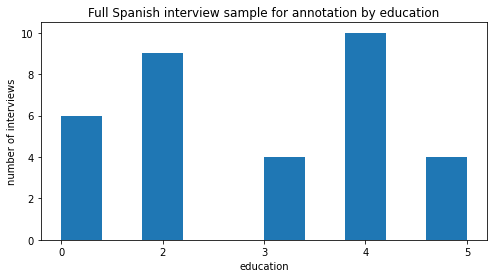

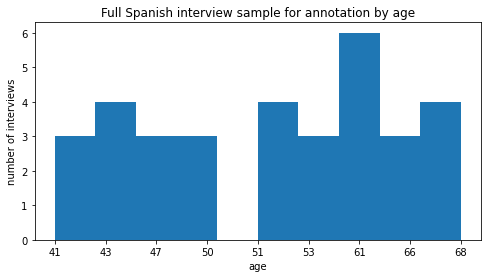

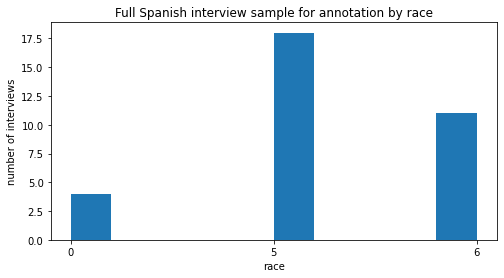

In [50]:
plot_global_education_age(spanish_interview_sample_for_annotation,
                          "Full Spanish interview sample for annotation", global_rates=False)

## VI. Join Engish and Spanish samples

In [51]:
spanish_interview_sample_for_annotation.assign(language='Spanish')
english_interview_sample_for_annotation.assign(language='English')
# english_interview_sample_for_annotation
# df.insert(0, 'Language', 'Spanish')
# df.insert(0, 'Language', 'English')
full_interview_sample_for_annotation = pd.concat(\
                    [spanish_interview_sample_for_annotation.assign(language='Spanish'),
                    english_interview_sample_for_annotation.assign(language='English')])\
                    .drop_duplicates(keep=False).reset_index(drop=True)

print_description(full_interview_sample_for_annotation, "Full interview sample for annotation",
                  verbose=True, test=True, global_rates=False)



*** Full interview sample for annotation ***
- Dataframe description:
        ethnicity       race        age  global_spirit_rating
count  69.000000  69.000000  69.000000             36.000000
mean    1.739130   4.797101  54.643494              4.096296
std     0.442326   1.356680  10.418424              0.513981
min     1.000000   0.000000  33.152634              2.600000
25%     1.000000   5.000000  47.137577              3.916667
50%     2.000000   5.000000  52.646133              4.000000
75%     2.000000   5.000000  61.273102              4.333333
max     2.000000   6.000000  82.469543              5.000000

- No. of enries in your DataFrame: 69
- No. of different education backgrounds: 6,  Education backgrounds: [0, 2, 3, 4, 5, 6.0]
- No. of different ages: 42,  Ages range: 33.15263366699219... 82.46954345703125
- No. of different races: 5,  Races: [0.0, 3.0, 4.0, 5.0, 6.0]
- >>> There are 13 participant IDs repeated in your sample: ***
 {'838-0225-001', '259-0225-016', '022-02

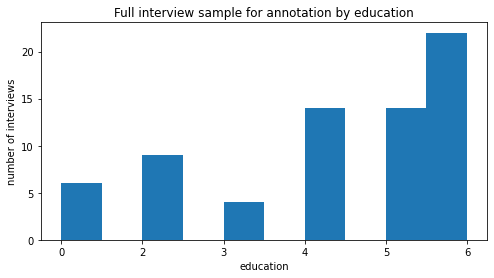

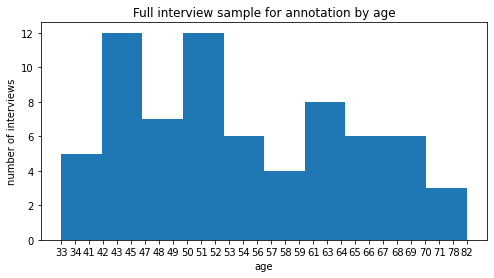

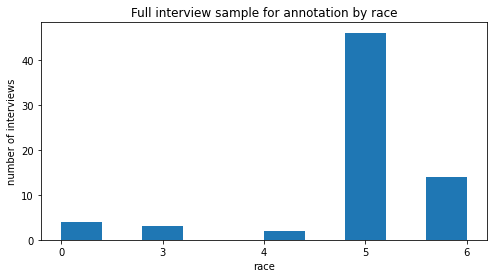

In [52]:
plot_global_education_age(pdf=full_interview_sample_for_annotation,
                          description="Full interview sample for annotation",
                          global_rates=False,
                          education=True,
                          race=True,
                          age=True)

## VI. Compare each sample with the general distribution (by ethnicity)

In [53]:
# TODO, if/when needed

## Outputs

In [54]:
spanish_interview_sample_for_annotation.to_csv('./output/spanish_interview_sample_for_annotation.csv', index=False)
english_interview_sample_for_annotation.to_csv('./output/english_interview_sample_for_annotation.csv', index=False)  
full_interview_sample_for_annotation.to_csv('./output/full_interview_sample_for_annotation.csv', index=False)  